In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

2022-08-21 19:11:16.071436: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/andrecox/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

2022-08-18 15:48:36.492255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 15:48:37.128566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30381 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [3]:
# tensorflow experimental batch size

BUFFER_SIZE = 1000
BATCH_SIZE = 64
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [6]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image


In [7]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [8]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [9]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

2022-08-18 15:48:40.185453: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-18 15:48:40.185813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


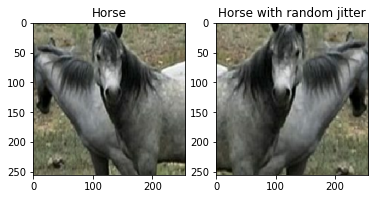

In [11]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

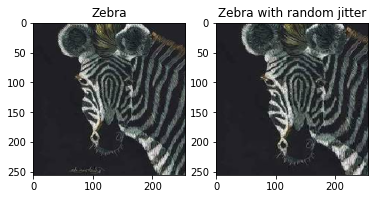

In [12]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [13]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

2022-08-18 15:48:44.080263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-18 15:48:44.709819: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


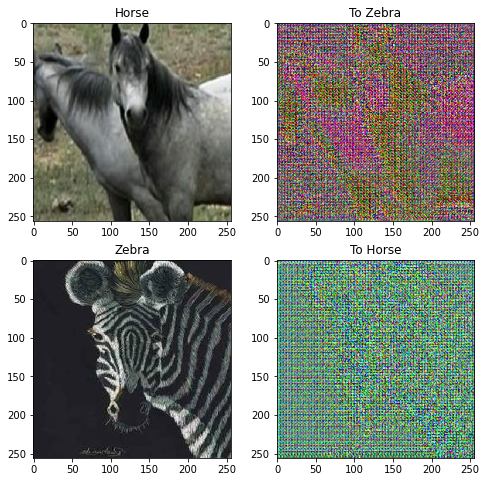

In [14]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

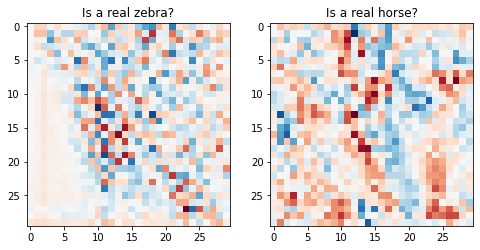

In [15]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [16]:
LAMBDA = 10

In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [21]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [22]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
def restore_checkpoint(checkpoint_path):
  checkpoint_path = checkpoint_path

  ckpt = tf.train.Checkpoint(generator_g=generator_g,
                             generator_f=generator_f,
                             discriminator_x=discriminator_x,
                             discriminator_y=discriminator_y,
                             generator_g_optimizer=generator_g_optimizer,
                             generator_f_optimizer=generator_f_optimizer,
                             discriminator_x_optimizer=discriminator_x_optimizer,
                             discriminator_y_optimizer=discriminator_y_optimizer)

  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

  # if a checkpoint exists, restore the latest checkpoint.
  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

  return ckpt_manager

In [24]:
EPOCHS = 30

In [25]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [26]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

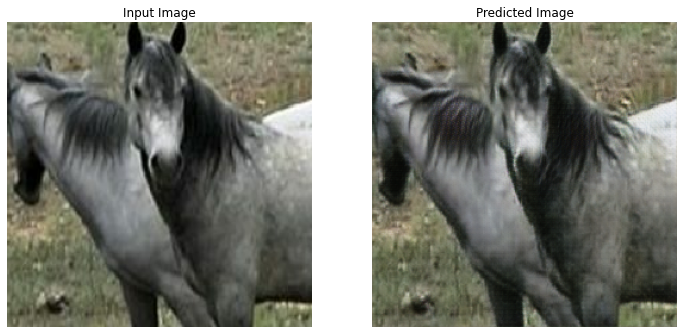

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-16
Time taken for epoch 30 is 44.78260540962219 sec



In [29]:
ckpt_manager = restore_checkpoint('./checkpoints/train')

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

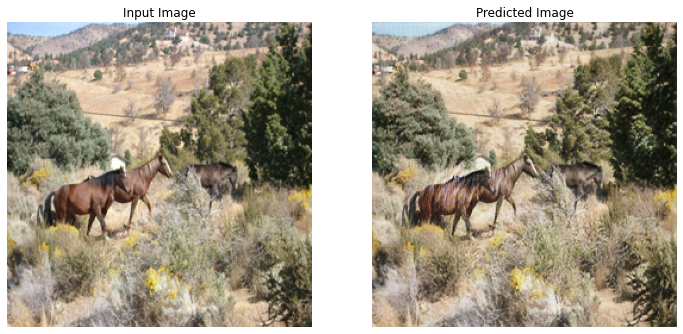

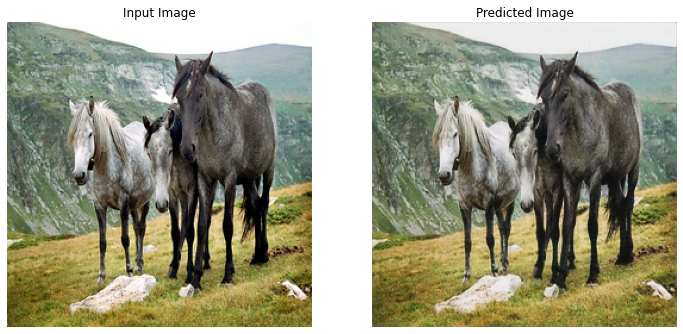

In [42]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)